In [26]:
# filelist
import cv2
import numpy as np
import os
from pathlib import Path
# root = os.getcwd() # Don't change this
# data_dirname = '/data_test/plantvillage/' # Change as you like 
# p = Path(root + data_dirname)
# p.mkdir(exist_ok=True) 

p = Path("C:/Users/mwels/Documents/Uni/11. Semester/Deep learning in visual recognition/Plant_leave_diseases_dataset_without_augmentation")
p.mkdir(exist_ok=True)


classes = [
  'Apple___Apple_scab',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  "all"
  ]

if "all" in classes:
  classes = os.listdir(p)

for c in classes:
  print(c,end=" ")
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))
# Pick first image of first class (i.e., cat)
# filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
print(len(filelist))

Apple___Apple_scab Apple___Black_rot Apple___Cedar_apple_rust Apple___healthy Background_without_leaves Blueberry___healthy Cherry___healthy Cherry___Powdery_mildew Corn___Cercospora_leaf_spot Gray_leaf_spot Corn___Common_rust Corn___healthy Corn___Northern_Leaf_Blight Grape___Black_rot Grape___Esca_(Black_Measles) Grape___healthy Grape___Leaf_blight_(Isariopsis_Leaf_Spot) Orange___Haunglongbing_(Citrus_greening) Peach___Bacterial_spot Peach___healthy Pepper,_bell___Bacterial_spot Pepper,_bell___healthy Potato___Early_blight Potato___healthy Potato___Late_blight Raspberry___healthy Soybean___healthy Squash___Powdery_mildew Strawberry___healthy Strawberry___Leaf_scorch Tomato___Bacterial_spot Tomato___Early_blight Tomato___healthy Tomato___Late_blight Tomato___Leaf_Mold Tomato___Septoria_leaf_spot Tomato___Spider_mites Two-spotted_spider_mite Tomato___Target_Spot Tomato___Tomato_mosaic_virus Tomato___Tomato_Yellow_Leaf_Curl_Virus 5357


In [6]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(40, 40, 3))
type(conv_base)

keras.engine.functional.Functional

In [31]:
from keras.layers import Dense,GlobalAveragePooling2D, Concatenate, Input, Flatten, Lambda
from keras.models import Model
# from src.fast_soft_sort.tf_ops import soft_rank


number_of_tiles = 9
image_net = conv_base
tiles = Input((9,40,40,3))
tile1 = Lambda(lambda x: x[:,0,:,:,:])(tiles) 
tile2 = Lambda(lambda x: x[:,1,:,:,:])(tiles) 
tile3 = Lambda(lambda x: x[:,2,:,:,:])(tiles) 
tile4 = Lambda(lambda x: x[:,3,:,:,:])(tiles) 
tile5 = Lambda(lambda x: x[:,4,:,:,:])(tiles) 
tile6 = Lambda(lambda x: x[:,5,:,:,:])(tiles) 
tile7 = Lambda(lambda x: x[:,6,:,:,:])(tiles) 
tile8 = Lambda(lambda x: x[:,7,:,:,:])(tiles) 
tile9 = Lambda(lambda x: x[:,8,:,:,:])(tiles) 
tile1 = preprocess_input(tile1) 
tile2 = preprocess_input(tile2) 
tile3 = preprocess_input(tile3) 
tile4 = preprocess_input(tile4) 
tile5 = preprocess_input(tile5) 
tile6 = preprocess_input(tile6) 
tile7 = preprocess_input(tile7) 
tile8 = preprocess_input(tile8) 
tile9 = preprocess_input(tile9) 

embedding_of_tile1 = image_net(tile1) 
embedding_of_tile2 = image_net(tile2)
embedding_of_tile3 = image_net(tile3) 
embedding_of_tile4 = image_net(tile4) 
embedding_of_tile5 = image_net(tile5) 
embedding_of_tile6 = image_net(tile6)
embedding_of_tile7 = image_net(tile7)
embedding_of_tile8 = image_net(tile8)
embedding_of_tile9 = image_net(tile9)

concatonation = Concatenate(axis=3)([
    embedding_of_tile1,
    embedding_of_tile2,
    embedding_of_tile3,
    embedding_of_tile4,
    embedding_of_tile5,
    embedding_of_tile6,
    embedding_of_tile7,
    embedding_of_tile8,
    embedding_of_tile9
    ])

out = Dense(500, activation="relu")(concatonation)
# out = Dense(500, activation="relu")(out)
out = Dense(9)(out)
out = Flatten()(out)
# out = Lambda(lambda x: soft_rank(x, regularization_strength=0.5))(out)

model = Model(inputs=tiles, outputs=out)

In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 9, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 lambda_27 (Lambda)             (None, 40, 40, 3)    0           ['input_5[0][0]']                
                                                                                                  
 lambda_28 (Lambda)             (None, 40, 40, 3)    0           ['input_5[0][0]']                
                                                                                                  
 lambda_29 (Lambda)             (None, 40, 40, 3)    0           ['input_5[0][0]']          

In [33]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 33
Number of pretrained base layers is 86


In [34]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator(x_train)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=tfr.keras.losses.MeanSquaredLoss(), metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 15 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=15)

c:\Users\mwels\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\mwels\AppData\Local\Temp\ipykernel_17304\2570840799.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/15
62/62 [==============================] - 76s 845ms/step - loss: 22.6201 - accuracy: 0.1136 - val_loss: 22.5961 - val_accuracy: 0.1039
Epoch 2/15
62/62 [==============================] - 42s 673ms/step - loss: 22.6138 - accuracy: 0.1197 - val_loss: 22.6326 - val_accuracy: 0.1039
Epoch 3/15
62/62 [==============================] - 43s 699ms/step - loss: 22.6215 - accuracy: 0.1040 - val_loss: 22.6446 - val_accuracy: 0.1320
Epoch 4/15
62/62 [==============================] - 45s 722ms/step - loss: 22.6192 - accuracy: 0.1146 - val_loss: 22.6255 - val_accuracy: 0.1148
Epoch 5/15
62/62 [==============================] - 44s 714ms/step - loss: 22.6257 - accuracy: 0.1126 - val_loss: 22.6242 - val_accuracy: 0.1187
Epoch 6/15
62/62 [==============================] - 44s 706ms/step - loss: 22.6339 - accuracy: 0.1070 - val_loss: 22.6262 - val_accuracy: 0.1094
Epoch 7/15
62/62 [==============================] - 46s 745ms/step - loss: 22.6313 - accuracy: 0.1133 - val_loss: 22.6172 - val_ac

In [27]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.permutation_tools import *
import tensorflow_ranking as tfr 

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator(x_train)
validation_generator = PermNetDataGenerator(x_test)


# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model 
# softmax_loss = tfr.keras.losses.get(tfr.keras.losses.RankingLossKey.MEAN_SQUARED_LOSS)
model.compile(optimizer=sgd_optimizer,loss=tfr.keras.losses.MeanSquaredLoss(), metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 15 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=15)


C:\Users\mwels\AppData\Local\Temp\ipykernel_17304\2510898503.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/15
62/62 [==============================] - 62s 684ms/step - loss: 23.0641 - accuracy: 0.1197 - val_loss: 23.0591 - val_accuracy: 0.1406
Epoch 2/15
62/62 [==============================] - 35s 565ms/step - loss: 23.0629 - accuracy: 0.1100 - val_loss: 23.1608 - val_accuracy: 0.0938
Epoch 3/15
62/62 [==============================] - 41s 664ms/step - loss: 23.0643 - accuracy: 0.1219 - val_loss: 23.1812 - val_accuracy: 0.1094
Epoch 4/15
62/62 [==============================] - 33s 535ms/step - loss: 23.0678 - accuracy: 0.1156 - val_loss: 23.1533 - val_accuracy: 0.1250
Epoch 5/15
62/62 [==============================] - 33s 524ms/step - loss: 23.0601 - accuracy: 0.1247 - val_loss: 23.1022 - val_accuracy: 0.1562
Epoch 6/15
62/62 [==============================] - 33s 525ms/step - loss: 23.0682 - accuracy: 0.1184 - val_loss: 23.2164 - val_accuracy: 0.1250
Epoch 7/15
62/62 [==============================] - 32s 521ms/step - loss: 23.0615 - accuracy: 0.1283 - val_loss: 23.1429 - val_ac

In [12]:
newDataGen = PermNetDataGenerator(input=x_ddtrain, batch_size=4, preprocess_func=preprocess_input)

In [22]:
X, y = next(newDataGen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


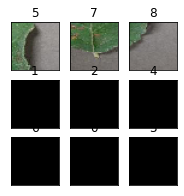

In [23]:
showPermImg(X[0],y[0])

In [40]:
test_gen = PermNetDataGenerator(x_test) # never do this
X, y = next(test_gen)
model.predict(np.expand_dims(X[0], axis=0))

1/1 [==============================] - 8s 8s/step


array([[-0.06172042, -0.12826368,  0.19051225, -0.33770105,  0.22509225,
         0.32174426, -0.19905451,  0.24421588, -0.1501222 ]],
      dtype=float32)